## MSDS458 Research Assignment 2
The goal is to compare `dense neural networks` and `convolutional neural networks` on `Fashion mnist` data.

In [4]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.datasets import fashion_mnist

# GridSearch Dependencies
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2
print("Keras version: ", keras.__version__)

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.1
Keras version:  2.4.0


# Helper Functions

In [5]:
def conv_stacker(model, number_of_layers, filters, dropout):
    if number_of_layers > 0:
        for layer in range(number_of_layers):
            model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
            if dropout==True:
                model.add(layers.Dropout(0.2))
    return model

def dense_stacker(model, number_of_layers, units):
    if number_of_layers > 0:
        for layer in range(number_of_layers):
            model.add(layers.Dense(units=units, activation='relu'))
    return model


def plot_accuracy(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(12, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()


def plot_confusion_matrix(train_images_norm, train_labels, model):
    """If you prefer color and a colorbar"""
    pred_classes = model.predict(train_images_norm)
    conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx)
    fig.colorbar(cax)


def print_results(grid_result):
    para = pd.DataFrame.from_dict(grid_result.cv_results_['params'])
    mean = pd.DataFrame(grid_result.cv_results_['mean_test_score'],columns=['mean_test_score'])
    stds = pd.DataFrame(grid_result.cv_results_['std_test_score'],columns=['std_test_score'])
    time = pd.DataFrame(grid_result.cv_results_['mean_fit_time'],columns=['mean_fit_time'])

    df = para.join(mean.join(stds)).join(time).sort_values('mean_test_score', ascending=False)
    df.reset_index().drop(columns=['index'])
    return df

# Preprocessing

In [6]:
# LOAD DATA
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('\ntrain_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_images = train_images.reshape((60000, 28, 28, 1))
train_images_norm = train_images.astype('float32')/255.

test_images = test_images.reshape((10000, 28, 28, 1))
test_images_norm = test_images.astype('float32')/255.

# Separate Validation Set and Train Set
val_images_norm, train_images_norm = train_images_norm[:10000], train_images_norm[10000:] 
val_labels, train_labels = train_labels[:10000], train_labels[10000:]


train_images:	(60000, 28, 28)
train_labels:	(60000,)
test_images:	(10000, 28, 28)
test_labels:	(10000,)


# Experimental Design
The purpose of this series of experiments is to determine the relationship between the number of convolutional and dense layers, and number of filters and units on model accuaracy and fit time on the benchmark fashion-mnist data set. These attirbutes will be parameterized with a model creation function and tested by varyign all inputs through gridsearch. The model architechture for all experiments will adhere to a common structure with the first layers consisting of Conv2D and MaxPooling models to handle feature learning and the last layers consisting of Dense layers, handling classification. After comparing all iterations of preset parameter combinations using gridsearch performance results are collected including accuracy and fit time. Finally, we train the model using the best parameters determined in the gridsearch exercise, output accuracy and loss charts to compare model performance in the validation and training sets, and visualize the confusion matrix to assess misclassification.

# EXPERIMENT 1:
The purpose of Experiment #1 is to vary the number of dense layer units and collect model performance results to determine the impact on training accuracy and fit time in seconds. The number of units to be iterated include 16, 32, 64, 256, 512, and 1024. 

In [27]:
def create_model(filters=64, units=64, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [16,32,64,256,512,1024]
filters = [64]
epochs = [10]
batches = [512]

param_grid = dict(
    units=units,
    filters = filters,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_images_norm, train_labels)
print_results(grid_result)

98/98 [==============================] - 26s 261ms/step - loss: 0.4904 - accuracy: 0.8273


,batch_size,filters,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
5,512,64,10,1024,0.86346,0.005305,17.843518
4,512,64,10,512,0.85588,0.001526,11.612391
3,512,64,10,256,0.85338,0.008048,9.700688
2,512,64,10,64,0.83620,0.004394,7.933003
1,512,64,10,32,0.81580,0.010644,7.600074
0,512,64,10,16,0.77962,0.007443,7.649470


Epoch 1/10
98/98 [==============================] - 27s 276ms/step - loss: 0.4896 - accuracy: 0.8265 - val_loss: 0.3457 - val_accuracy: 0.8791
Epoch 2/10
98/98 [==============================] - 27s 278ms/step - loss: 0.3050 - accuracy: 0.8922 - val_loss: 0.3035 - val_accuracy: 0.8945
Epoch 3/10
98/98 [==============================] - 27s 273ms/step - loss: 0.2616 - accuracy: 0.9063 - val_loss: 0.2771 - val_accuracy: 0.8995
Epoch 4/10
98/98 [==============================] - 27s 272ms/step - loss: 0.2284 - accuracy: 0.9187 - val_loss: 0.2538 - val_accuracy: 0.9082
Epoch 5/10
98/98 [==============================] - 27s 273ms/step - loss: 0.2060 - accuracy: 0.9246 - val_loss: 0.2398 - val_accuracy: 0.9145
Epoch 6/10
98/98 [==============================] - 27s 271ms/step - loss: 0.1755 - accuracy: 0.9374 - val_loss: 0.2344 - val_accuracy: 0.9160
Epoch 7/10
98/98 [==============================] - 27s 272ms/step - loss: 0.1599 - accuracy: 0.9419 - val_loss: 0.2530 - val_accuracy: 0.9097

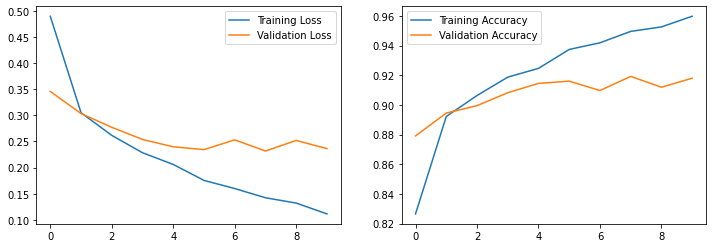

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


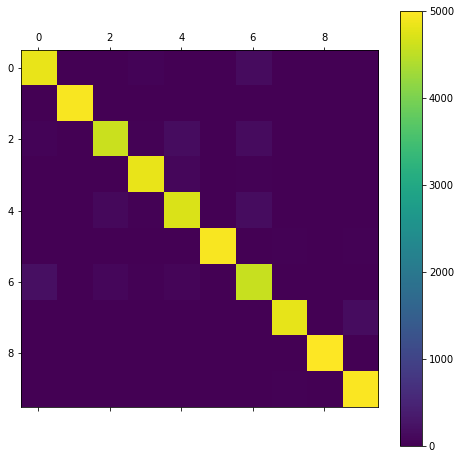

In [5]:
# Best Model
def create_model(filters=64, units=1024, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)
history = model.fit(train_images_norm, train_labels,epochs=10,batch_size=512,validation_data=(val_images_norm,val_labels))
plot_accuracy(history)
plot_confusion_matrix(train_images_norm, train_labels, model)

# Results
In experiment #1 a neural network consisting of 1 convolutinal layer and 1 dense layer was trained varying the number of units for the dense layer. A clear relationship between the number of dense layer units and model accuracy and fit time was demonstrated. As the number of units increased, model performance and training time both increased. A maximum of 91.8% accuracy was achieved in 10 epochs for this experiment. Notably fit time nearly tripled from the initial run at 16 units per dense layer to the final run at 1024 units. After 2 epochs, however, model peformance between training and validation accuracy clearly diverged and continued to separated with additional epochs. 

# Experiment #2
The purpose of Experiment #1 is to vary the number of convolutional layer filters and collect model performance results to determine the impact on training accuracy and fit time in seconds. The number of filters to be iterated include 16, 32, 64, 256, 512, and 1024. 

In [6]:
def create_model(filters=64, units=1024, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = Sequential()
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [1024]
filters = [16,32,64,256,512,1024]
epochs = [10]
batches = [512]

param_grid = dict(
    units=units,
    filters = filters,
    nb_epoch=epochs,
    batch_size=batches,
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_images_norm, train_labels)
print_results(grid_result)

98/98 [==============================] - 390s 4s/step - loss: 0.6099 - accuracy: 0.8160


,batch_size,filters,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
5,512,1024,10,1024,0.87664,0.003933,264.354646
4,512,512,10,1024,0.87070,0.004680,134.406799
3,512,256,10,1024,0.86882,0.008413,68.375863
2,512,64,10,1024,0.86598,0.003537,17.721482
1,512,32,10,1024,0.85714,0.006431,8.986112
0,512,16,10,1024,0.84518,0.004583,4.876715


Epoch 1/10
98/98 [==============================] - 410s 4s/step - loss: 0.5662 - accuracy: 0.8263 - val_loss: 0.3043 - val_accuracy: 0.8943
Epoch 2/10
98/98 [==============================] - 413s 4s/step - loss: 0.2693 - accuracy: 0.9029 - val_loss: 0.2625 - val_accuracy: 0.9062
Epoch 3/10
98/98 [==============================] - 410s 4s/step - loss: 0.2230 - accuracy: 0.9190 - val_loss: 0.2445 - val_accuracy: 0.9098
Epoch 4/10
98/98 [==============================] - 410s 4s/step - loss: 0.1811 - accuracy: 0.9343 - val_loss: 0.2389 - val_accuracy: 0.9140
Epoch 5/10
98/98 [==============================] - 410s 4s/step - loss: 0.1553 - accuracy: 0.9432 - val_loss: 0.2320 - val_accuracy: 0.9201
Epoch 6/10
98/98 [==============================] - 410s 4s/step - loss: 0.1253 - accuracy: 0.9549 - val_loss: 0.2254 - val_accuracy: 0.9221
Epoch 7/10
98/98 [==============================] - 411s 4s/step - loss: 0.1074 - accuracy: 0.9614 - val_loss: 0.2493 - val_accuracy: 0.9171
Epoch 8/10
98

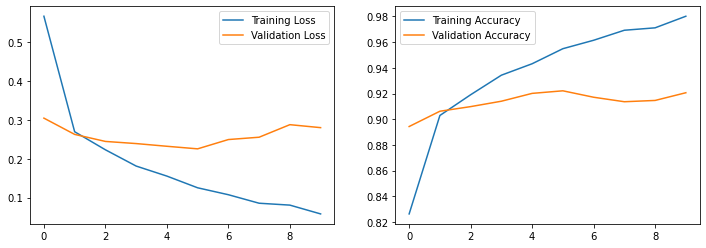

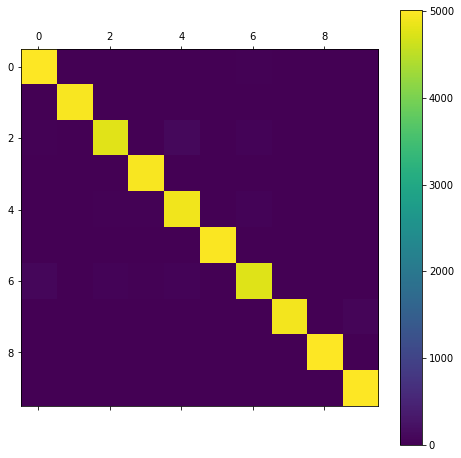

In [7]:
# Best Model
def create_model(filters=1024, units=1024, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)
history = model.fit(train_images_norm, train_labels,epochs=10,batch_size=512,validation_data=(val_images_norm,val_labels))
plot_accuracy(history)
plot_confusion_matrix(train_images_norm, train_labels, model)

# Experiment #3
The purpose of Experiment #3 is to vary the number of additional dense layers and collect model performance results to determine the impact on training accuracy and fit time in seconds. All other parameters for each layer will be kept the same.

In [38]:
def create_model(conv_layers=0, dense_layers=0,dropout=1, filters=64, units=1024, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = Sequential()
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model = conv_stacker(model, number_of_layers=conv_layers, filters=filters, dropout=dropout)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model = dense_stacker(model, number_of_layers=dense_layers, units=units)
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [32]
filters = [32]
epochs = [20]
batches = [512]
conv_layers = [0]
dense_layers = [0, 1, 2]
dropout = [True]

param_grid = dict(
    units=units,
    filters = filters,
    nb_epoch=epochs,
    batch_size=batches,
    conv_layers = conv_layers,
    dense_layers = dense_layers,
    dropout = dropout
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_images_norm, train_labels)
print_results(grid_result)

98/98 [==============================] - 6s 60ms/step - loss: 0.7986 - accuracy: 0.7373


,batch_size,conv_layers,dense_layers,dropout,filters,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
0,512,0,0,True,32,20,32,0.81114,0.006354,4.232587
1,512,0,1,True,32,20,32,0.78818,0.014436,4.377412
2,512,0,2,True,32,20,32,0.78356,0.003659,4.552619


# Results
The purpose of Experiment #3 was to vary the number of additional dense layers and collect model performance results to determine the impact on training accuracy and fit time in seconds. From the gridsearch results it was clear that additional dense layers did improve model training despite adding fit time

# Experiment #4
The purpose of Experiment #4 is to vary the number of additional convolutional layers and collect model performance results to determine the impact on training accuracy and fit time in seconds. All other parameters for each layer will be kept the same.

In [7]:
def create_model(conv_layers=0, dense_layers=0,dropout=1, filters=64, units=1024, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = Sequential()
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model = conv_stacker(model, number_of_layers=conv_layers, filters=filters, dropout=dropout)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model = dense_stacker(model, number_of_layers=dense_layers, units=units)
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [32]
filters = [32]
epochs = [20]
batches = [512]
conv_layers = [0, 1, 2, 3, 4]
dense_layers = [0]
dropout = [False]

param_grid = dict(
    units=units,
    filters = filters,
    nb_epoch=epochs,
    batch_size=batches,
    conv_layers = conv_layers,
    dense_layers = dense_layers,
    dropout = dropout
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_images_norm, train_labels)
print_results(grid_result)

98/98 [==============================] - 6s 57ms/step - loss: 0.7183 - accuracy: 0.7595


,batch_size,conv_layers,dense_layers,dropout,filters,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
0,512,0,0,False,32,20,32,0.81206,0.005113,4.415956
1,512,1,0,False,32,20,32,0.78816,0.011911,6.097010
2,512,2,0,False,32,20,32,0.77442,0.005850,7.431966
3,512,3,0,False,32,20,32,0.74358,0.008448,8.378686
4,512,4,0,False,32,20,32,0.71556,0.005839,8.752694


# Results
The purpose of Experiment #4 was to vary the number of additional convolutional layers and collect model performance results to determine the impact on training accuracy and fit time in seconds. From the gridsearch results it was clear that additional convolutional layers did not improve model training despite increasing fit time and worsenede accuracy significantly.

# Experiment #5
The purpose of Experiment #5 is to vary the number of additional convolutional layers with Dropout to determine the impact on training accuracy and fit time in seconds. All other parameters for each layer will be kept the same.

In [43]:
def create_model(conv_layers=0, dense_layers=0,dropout=1, filters=64, units=1024, optimizer='adam', activation='relu', loss='sparse_categorical_crossentropy'):
    # Create model
    model = Sequential()
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), activation=activation, input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2),strides=2))
    model = conv_stacker(model, number_of_layers=conv_layers, filters=filters, dropout=dropout)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    model = dense_stacker(model, number_of_layers=dense_layers, units=units)
    model.add(layers.Dense(units=10, activation=tf.nn.softmax))
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

# grid search parameters
units = [32]
filters = [32]
epochs = [20]
batches = [512]
conv_layers = [0, 1, 2, 3, 4, 5]
dense_layers = [0]
dropout = [True]

param_grid = dict(
    units=units,
    filters = filters,
    nb_epoch=epochs,
    batch_size=batches,
    conv_layers = conv_layers,
    dense_layers = dense_layers,
    dropout = dropout
)
grid_result = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(train_images_norm, train_labels)
print_results(grid_result)

98/98 [==============================] - 6s 60ms/step - loss: 0.7540 - accuracy: 0.7494


,batch_size,conv_layers,dense_layers,dropout,filters,nb_epoch,units,mean_test_score,std_test_score,mean_fit_time
0,512,0,0,True,32,20,32,0.80844,0.003977,4.456256
1,512,1,0,True,32,20,32,0.79204,0.014163,6.580188
2,512,2,0,True,32,20,32,0.77272,0.015716,8.178373
3,512,3,0,True,32,20,32,0.75040,0.005801,9.118011
4,512,4,0,True,32,20,32,0.73152,0.006653,10.006982
5,512,5,0,True,32,20,32,0.70526,0.010221,10.097823


# Results
The purpose of Experiment #5 was to vary the number of additional convolutional layers with Dropout and collect model performance results to determine the impact on training accuracy and fit time in seconds. From the gridsearch results it was clear that additional convolutional layers with dropout did not improve model training despite increasing fit time and worsening accruacy modestly more than Experiment #4.

# Conclusion
The purpose of this series of experiments was to determine the relationship between the number of convolutional and dense layers, and number of filters and units on model accuaracy and fit time on the benchmark fashion-mnist data set. These attirbutes were be parameterized with a model creation function and tested by varying all inputs through gridsearch. After comparing all iterations of preset parameter combinations using gridsearch a clear pattern emerged. The number of filters for convolutional layers had the greatest impact on performance with a maximum accuracy of 92.2% accuracy in the validation set with 1024 filters on a single convolutional layer. Adding convolutional layers resulted in counterintuitive results with worsening accuracy with each additional layer added in addition to the longer training times. Similar results were observed for Dense layers. A maximum of 91.8% accuracy in the validation set with 1024 unit was observed for the Dense layer Experiment #1. Interestingly, additional dense layers also worsened accuracy and increased fit times. It was clear however that the convolutional layer and filters had the greatest impact on accuracy and fit time compared to Dense layer and its units. The training times were quite long and with additional epochs the improvenment in training accuracy was increasing smaller. Perhaps dropout and max pooling layers could help with overfitting and higher accuracy could be achieved with more layers, however the fit times may become prohibitively expensive with addition filters and layers for a relatively minor and proportionally smaller return on the added investment. At some point one must evaluate the tradeoff and settle for slightly worse performance for reasonable training times. Further investigation is warranted to address the counterintuitive findings of adding additional convolutional and dense layers.

In [21]:
activation_functions = ['deserialize', 'elu', 'exponential', 'get', 'hard_sigmoid', 'linear', 'relu','selu', 
                        'serialize', 'sigmoid', 'softmax', 'softplus', 'softsign', 'swish', 'tanh',]
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'rmsprop']
losses = ['binary_crossentropy','categorical_crossentropy','sparse_categorical_crossentropy'
          ,'poisson','kl_divergence']
learning_rates = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]